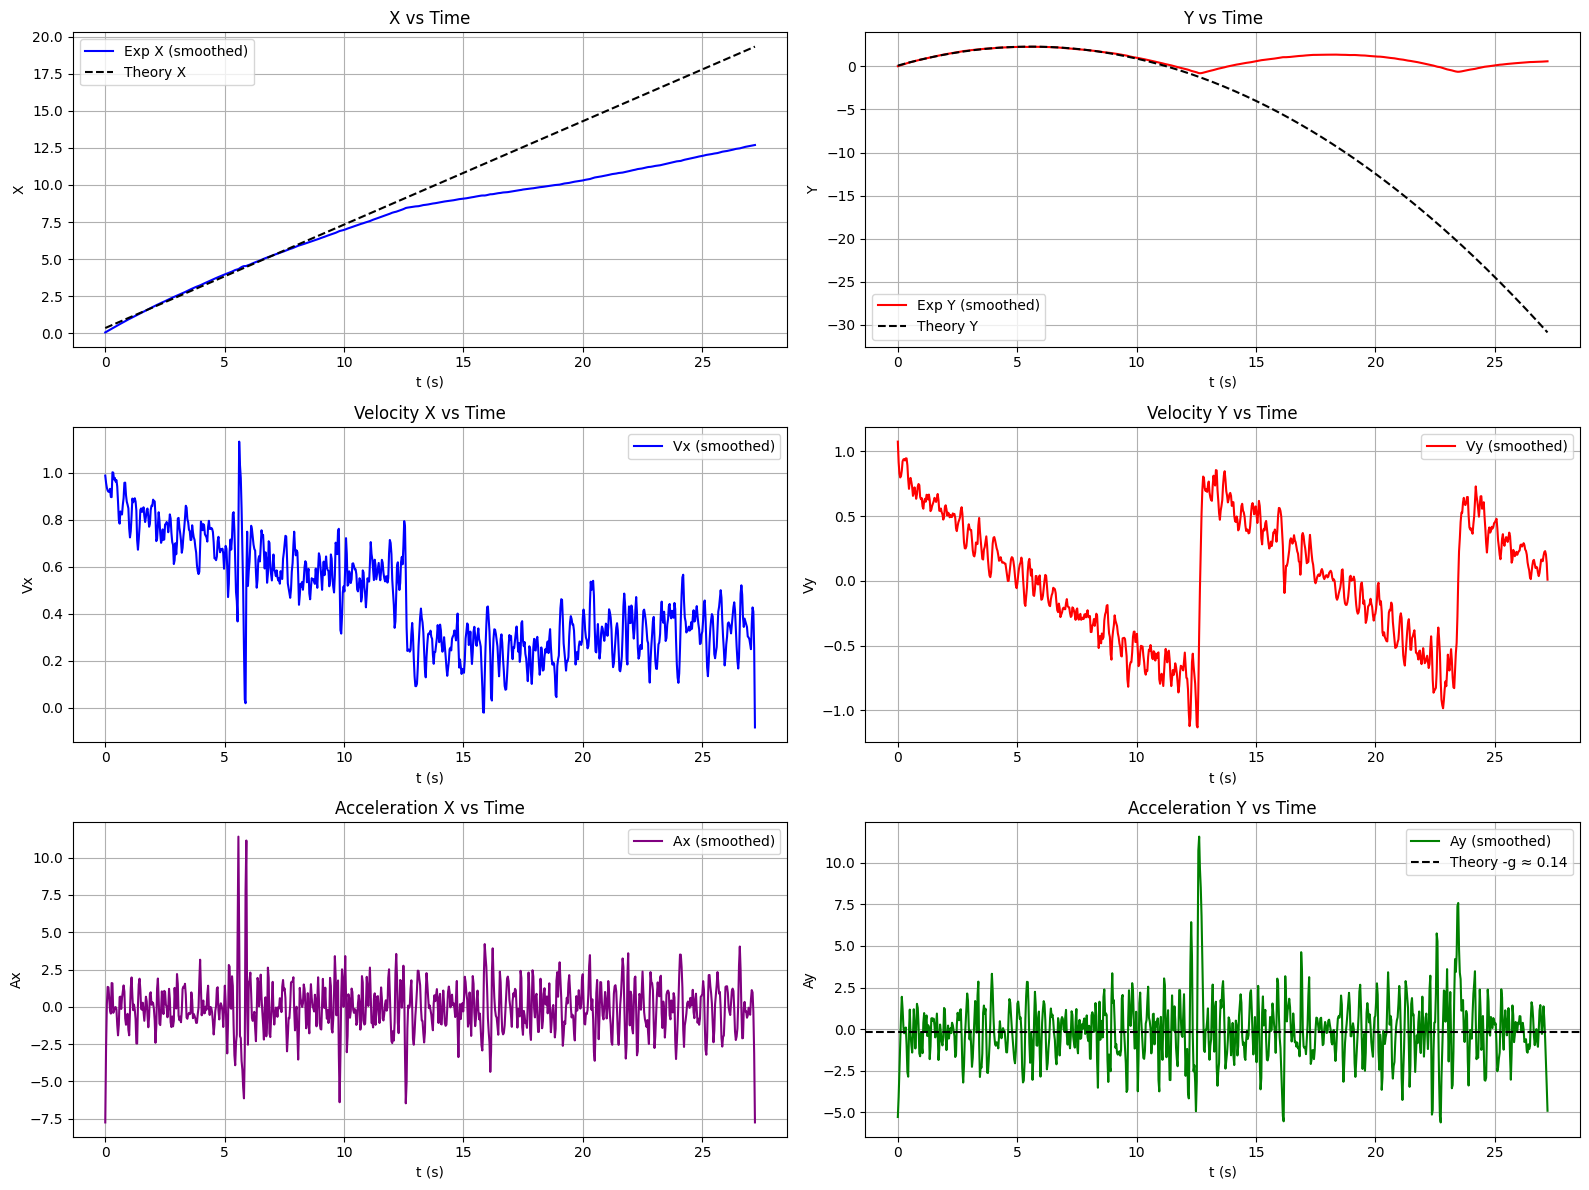

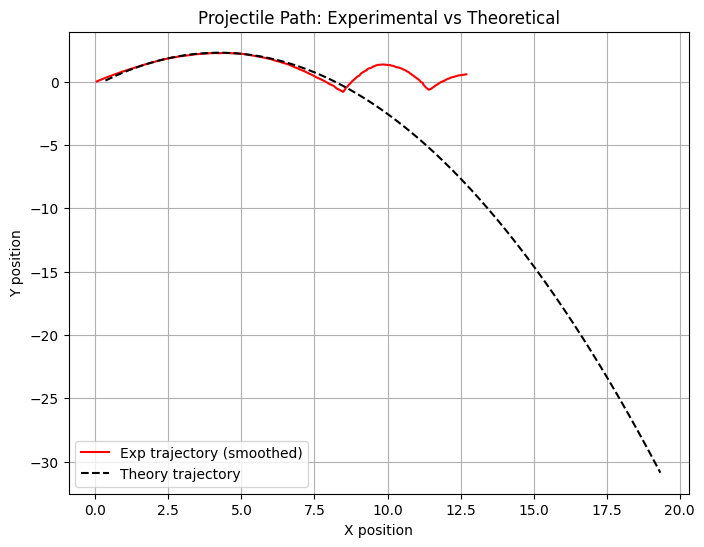


=== Model Fit Summary ===
Estimated v0x ≈ 0.698 m/s
Estimated v0y ≈ 0.790 m/s
Estimated g   ≈ 0.142 m/s²


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit

# ========= Parameters =========
file_path = "Untitled spreadsheet - Sheet1 (1).csv"
savgol_window = 11   # smoothing window size (odd only)
savgol_poly = 3

# ========= 1. Load & clean data =========
data = pd.read_csv(file_path, header=0)
data = data.rename(columns={"Unnamed: 0": "t", "Unnamed: 1": "x", "Unnamed: 2": "y"})

for col in ["t", "x", "y"]:
    data[col] = pd.to_numeric(data[col], errors="coerce")

data = data.dropna().reset_index(drop=True)

# ========= 2. Reset time =========
t = data["t"].values
t = t - t.min()
x = data["x"].values
y = data["y"].values

# ========= 3. Compute velocities & accelerations =========
vx = np.gradient(x, t)
vy = np.gradient(y, t)
ax = np.gradient(vx, t)
ay = np.gradient(vy, t)

# ========= 4. Smooth =========
if savgol_window >= len(t):
    savgol_window = len(t) - (1 - len(t) % 2)

x_s = savgol_filter(x, savgol_window, savgol_poly)
y_s = savgol_filter(y, savgol_window, savgol_poly)
vx_s = savgol_filter(vx, savgol_window, savgol_poly)
vy_s = savgol_filter(vy, savgol_window, savgol_poly)
ax_s = savgol_filter(ax, savgol_window, savgol_poly)
ay_s = savgol_filter(ay, savgol_window, savgol_poly)

# ========= 5. Fit projectile model =========
def x_model(t, v0x, x0):
    return x0 + v0x*t

def y_model(t, v0y, y0, g):
    return y0 + v0y*t - 0.5*g*t**2

# Fit to first segment (before bounce)
cut_index = np.argmax(vy_s > 0)
if cut_index == 0:
    cut_index = len(t) // 3
t_fit = t[:cut_index]
x_fit = x_s[:cut_index]
y_fit = y_s[:cut_index]

# Fit x(t)
popt_x, _ = curve_fit(x_model, t_fit, x_fit, p0=[vx_s[0], x_fit[0]])
v0x_fit, x0_fit = popt_x

# Fit y(t)
popt_y, _ = curve_fit(y_model, t_fit, y_fit, p0=[vy_s[0], y_fit[0], 9.8])
v0y_fit, y0_fit, g_fit = popt_y

# Theoretical trajectory
t_theory = np.linspace(t.min(), t.max(), 300)
x_theory = x_model(t_theory, v0x_fit, x0_fit)
y_theory = y_model(t_theory, v0y_fit, y0_fit, g_fit)

# ========= 6. Plotting =========
plt.figure(figsize=(16,12))

# X vs time
plt.subplot(3,2,1)
plt.plot(t, x_s, 'b', label="Exp X (smoothed)")
plt.plot(t_theory, x_theory, 'k--', label="Theory X")
plt.title("X vs Time"); plt.xlabel("t (s)"); plt.ylabel("X"); plt.grid(); plt.legend()

# Y vs time
plt.subplot(3,2,2)
plt.plot(t, y_s, 'r', label="Exp Y (smoothed)")
plt.plot(t_theory, y_theory, 'k--', label="Theory Y")
plt.title("Y vs Time"); plt.xlabel("t (s)"); plt.ylabel("Y"); plt.grid(); plt.legend()

# Vx vs time
plt.subplot(3,2,3)
plt.plot(t, vx_s, 'b', label="Vx (smoothed)")
plt.title("Velocity X vs Time"); plt.xlabel("t (s)"); plt.ylabel("Vx"); plt.grid(); plt.legend()

# Vy vs time
plt.subplot(3,2,4)
plt.plot(t, vy_s, 'r', label="Vy (smoothed)")
plt.title("Velocity Y vs Time"); plt.xlabel("t (s)"); plt.ylabel("Vy"); plt.grid(); plt.legend()

# Ax vs time
plt.subplot(3,2,5)
plt.plot(t, ax_s, 'purple', label="Ax (smoothed)")
plt.title("Acceleration X vs Time"); plt.xlabel("t (s)"); plt.ylabel("Ax"); plt.grid(); plt.legend()

# Ay vs time
plt.subplot(3,2,6)
plt.plot(t, ay_s, 'g', label="Ay (smoothed)")
plt.axhline(-g_fit, color="k", ls="--", label=f"Theory -g ≈ {g_fit:.2f}")
plt.title("Acceleration Y vs Time"); plt.xlabel("t (s)"); plt.ylabel("Ay"); plt.grid(); plt.legend()

plt.tight_layout()
plt.show()

# ========= 7. Trajectory comparison =========
plt.figure(figsize=(8,6))
plt.plot(x_s, y_s, 'r', label="Exp trajectory (smoothed)")
plt.plot(x_theory, y_theory, 'k--', label="Theory trajectory")
plt.title("Projectile Path: Experimental vs Theoretical")
plt.xlabel("X position"); plt.ylabel("Y position"); plt.legend(); plt.grid()
plt.show()

# ========= 8. Print summary =========
print("\n=== Model Fit Summary ===")
print(f"Estimated v0x ≈ {v0x_fit:.3f} m/s")
print(f"Estimated v0y ≈ {v0y_fit:.3f} m/s")
print(f"Estimated g   ≈ {g_fit:.3f} m/s²")


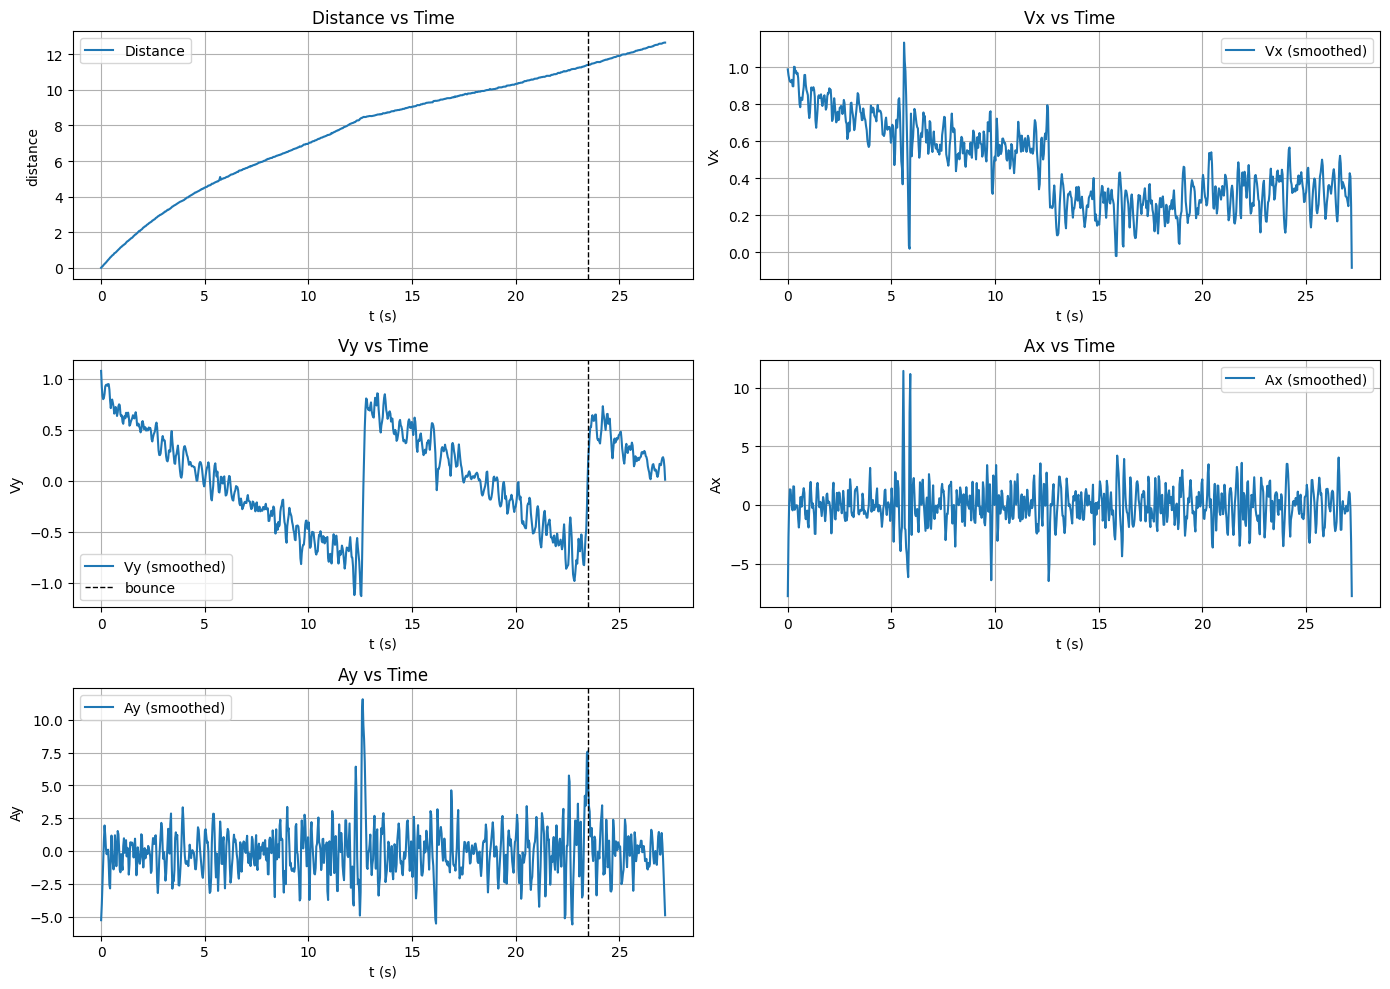

Detected bounce times (s): [23.466]
Estimated g from data (positive value) ≈ 0.085 m/s^2

Per-bounce summary (t, v_before, v_after, restitution e):
t=23.466s, v_before=-0.479, v_after=0.327, e=0.682


In [ ]:
# Put this in a .py or notebook and run. Adjust file_path as needed.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, find_peaks

# ---------- Parameters ----------
file_path = "Untitled spreadsheet - Sheet1 (1).csv"  # change if needed
savgol_window = 11   # must be odd; increase to smooth more
savgol_poly = 3
impact_search_window_s = 0.1  # seconds around candidate for sampling pre/post velocities

# ---------- 1. Load & clean ----------
data = pd.read_csv(file_path, header=0)
data = data.rename(columns={"Unnamed: 0": "t", "Unnamed: 1": "x", "Unnamed: 2": "y"})
for col in ["t","x","y"]:
    data[col] = pd.to_numeric(data[col], errors="coerce")
data = data.dropna().reset_index(drop=True)

# ---------- 2. Time shift ----------
t = data["t"].values
t = t - t.min()
x = data["x"].values
y = data["y"].values

# ---------- 3. Compute velocities & accelerations ----------
vx = np.gradient(x, t)
vy = np.gradient(y, t)
ax = np.gradient(vx, t)
ay = np.gradient(vy, t)

# ---------- 4. Smooth ----------
# Window must be <= len(array) and odd
if savgol_window >= len(t):
    savgol_window = len(t) - (1 - len(t)%2)  # make it odd and smaller
vx_s = savgol_filter(vx, savgol_window, savgol_poly)
vy_s = savgol_filter(vy, savgol_window, savgol_poly)
ax_s = savgol_filter(ax, savgol_window, savgol_poly)
ay_s = savgol_filter(ay, savgol_window, savgol_poly)

# ---------- 5. Detect bounce events ----------
# Candidate impacts: large positive spike in |ay| and v_y sign change (down -> up)
# Find peaks in |ay_s|
peaks, _ = find_peaks(np.abs(ay_s), height=np.std(ay_s)*3)  # threshold heuristic
bounce_candidates = []
for p in peaks:
    # Ensure vy changes sign around p (from negative just before to positive just after)
    if p-1>=0 and p+1 < len(vy_s):
        if vy_s[p-1] < 0 and vy_s[p+1] > 0:  # strict sign change
            bounce_candidates.append(p)
# Keep unique and sort
bounce_indices = sorted(bounce_candidates)

# If more than 2 candidates, keep the two largest |ay_s| peaks (most likely real bounces)
if len(bounce_indices) > 2:
    # sort by ay_s magnitude and keep top 2
    bounce_indices = sorted(bounce_indices, key=lambda i: np.abs(ay_s[i]), reverse=True)[:2]
    bounce_indices = sorted(bounce_indices)

bounce_times = t[bounce_indices]

# ---------- 6. Estimate coefficient of restitution for each bounce ----------
def sample_near_index(idx, t, vy_s, dt_window=impact_search_window_s):
    # sample just before and just after impact within dt_window
    t0 = t[idx]
    before_mask = (t >= t0 - dt_window) & (t < t0 - dt_window/10)
    after_mask  = (t >  t0 + dt_window/10) & (t <= t0 + dt_window)
    v_before = np.median(vy_s[before_mask]) if np.any(before_mask) else np.nan
    v_after  = np.median(vy_s[after_mask]) if np.any(after_mask) else np.nan
    return v_before, v_after

restitutions = []
for idx in bounce_indices:
    v_bef, v_aft = sample_near_index(idx, t, vy_s, dt_window=impact_search_window_s)
    if np.isfinite(v_bef) and np.isfinite(v_aft) and np.abs(v_bef) > 1e-6:
        e = np.abs(v_aft) / np.abs(v_bef)
    else:
        e = np.nan
    restitutions.append((t[idx], v_bef, v_aft, e))

# ---------- 7. Estimate gravity ----------
# Exclude windows around bounce indices (±impact_search_window_s)
mask = np.ones_like(t, dtype=bool)
for idx in bounce_indices:
    t0 = t[idx]
    mask &= ~((t >= t0 - impact_search_window_s) & (t <= t0 + impact_search_window_s))
# Mean acceleration in y during flight segments (gravity should be negative)
g_est = -np.median(ay_s[mask])  # positive number estimate for g

# ---------- 8. Plots with bounce markers ----------
plt.figure(figsize=(14,10))
plt.subplot(3,2,1)
distance = np.sqrt((x-x[0])**2 + (y-y[0])**2)
plt.plot(t, distance, label='Distance')
for bt in bounce_times: plt.axvline(bt, color='k', ls='--', lw=1)
plt.title("Distance vs Time"); plt.xlabel("t (s)"); plt.ylabel("distance"); plt.legend(); plt.grid()

plt.subplot(3,2,2)
plt.plot(t, vx_s, label='Vx (smoothed)')
plt.title("Vx vs Time"); plt.xlabel("t (s)"); plt.ylabel("Vx"); plt.grid(); plt.legend()

plt.subplot(3,2,3)
plt.plot(t, vy_s, label='Vy (smoothed)')
for bt in bounce_times: plt.axvline(bt, color='k', ls='--', lw=1, label='bounce' if bt==bounce_times[0] else None)
plt.title("Vy vs Time"); plt.xlabel("t (s)"); plt.ylabel("Vy"); plt.legend(); plt.grid()

plt.subplot(3,2,4)
plt.plot(t, ax_s, label='Ax (smoothed)')
plt.title("Ax vs Time"); plt.xlabel("t (s)"); plt.ylabel("Ax"); plt.grid(); plt.legend()

plt.subplot(3,2,5)
plt.plot(t, ay_s, label='Ay (smoothed)')
for bt in bounce_times: plt.axvline(bt, color='k', ls='--', lw=1)
plt.title("Ay vs Time"); plt.xlabel("t (s)"); plt.ylabel("Ay"); plt.grid(); plt.legend()

plt.tight_layout()
plt.show()

# ---------- 9. Print summary ----------
print("Detected bounce times (s):", np.round(bounce_times, 3).tolist())
print("Estimated g from data (positive value) ≈ {:.3f} m/s^2".format(g_est))
print("\nPer-bounce summary (t, v_before, v_after, restitution e):")
for (t_idx, v_bef, v_aft, e) in restitutions:
    print(f"t={t_idx:.3f}s, v_before={v_bef:.3f}, v_after={v_aft:.3f}, e={np.nan if np.isnan(e) else round(e,3)}")


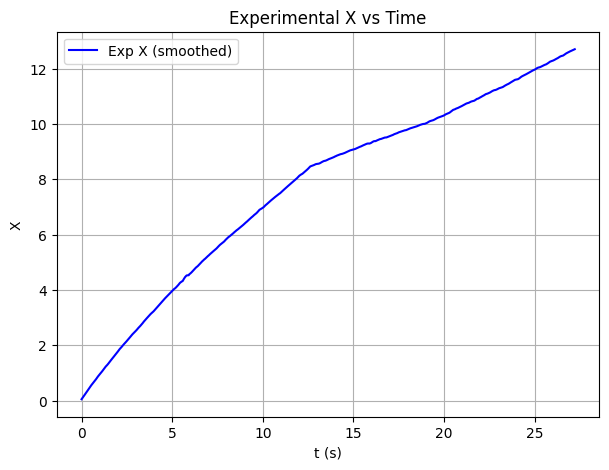

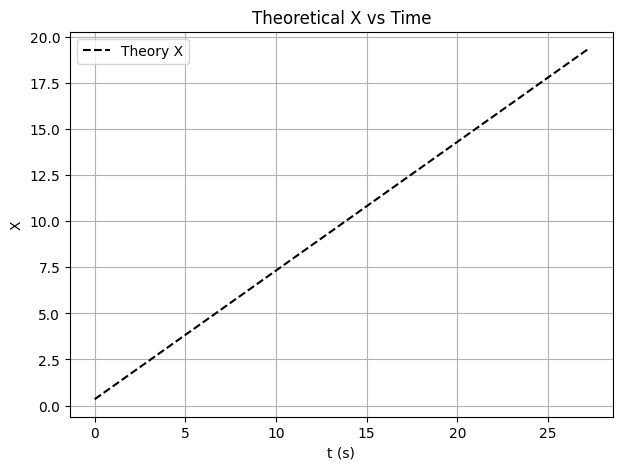

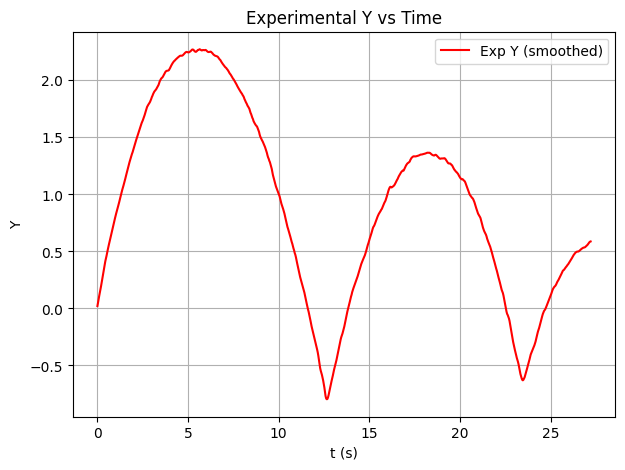

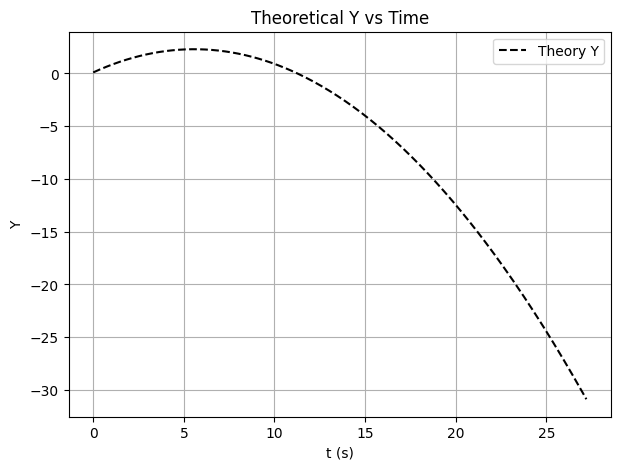

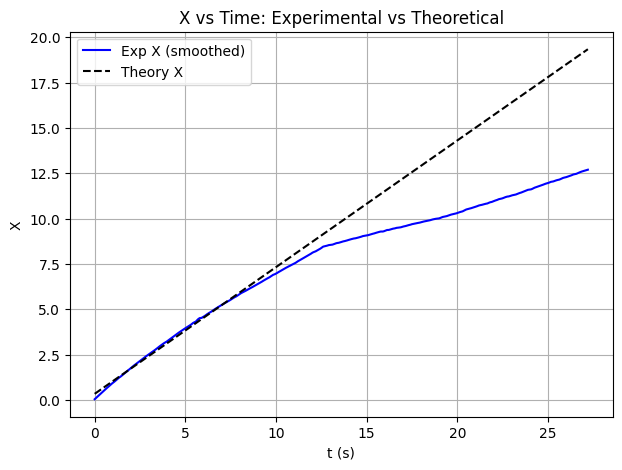

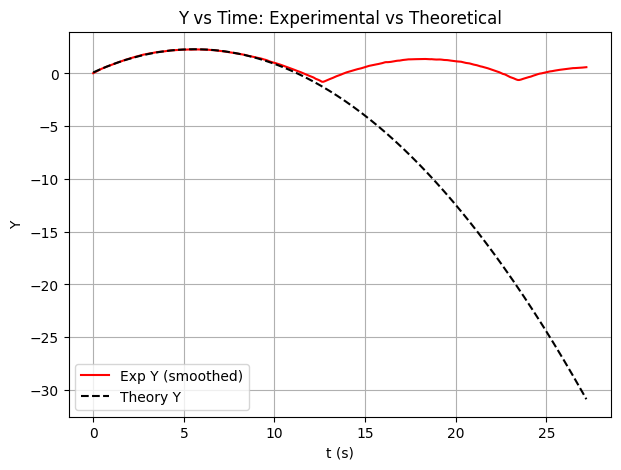


=== Model Fit Summary ===
Estimated v0x ≈ 0.698 m/s
Estimated v0y ≈ 0.790 m/s
Estimated g   ≈ 0.142 m/s²


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit

# ========= Parameters =========
file_path = "Untitled spreadsheet - Sheet1 (1).csv"
savgol_window = 11   # smoothing window size (odd only)
savgol_poly = 3

# ========= 1. Load & clean data =========
data = pd.read_csv(file_path, header=0)
data = data.rename(columns={"Unnamed: 0": "t", "Unnamed: 1": "x", "Unnamed: 2": "y"})

for col in ["t", "x", "y"]:
    data[col] = pd.to_numeric(data[col], errors="coerce")

data = data.dropna().reset_index(drop=True)

# ========= 2. Reset time =========
t = data["t"].values
t = t - t.min()
x = data["x"].values
y = data["y"].values

# ========= 3. Smooth data =========
if savgol_window >= len(t):
    savgol_window = len(t) - (1 - len(t) % 2)

x_s = savgol_filter(x, savgol_window, savgol_poly)
y_s = savgol_filter(y, savgol_window, savgol_poly)

# ========= 4. Fit projectile model =========
def x_model(t, v0x, x0):
    return x0 + v0x*t

def y_model(t, v0y, y0, g):
    return y0 + v0y*t - 0.5*g*t**2

# Fit to first segment (before bounce)
cut_index = np.argmax(np.gradient(y_s, t) > 0)
if cut_index == 0:
    cut_index = len(t) // 3
t_fit = t[:cut_index]
x_fit = x_s[:cut_index]
y_fit = y_s[:cut_index]

# Fit x(t)
popt_x, _ = curve_fit(x_model, t_fit, x_fit, p0=[(x_fit[-1]-x_fit[0])/(t_fit[-1]-t_fit[0]), x_fit[0]])
v0x_fit, x0_fit = popt_x

# Fit y(t)
popt_y, _ = curve_fit(y_model, t_fit, y_fit, p0=[0, y_fit[0], 9.8])
v0y_fit, y0_fit, g_fit = popt_y

# Generate theoretical curves
t_theory = np.linspace(t.min(), t.max(), 300)
x_theory = x_model(t_theory, v0x_fit, x0_fit)
y_theory = y_model(t_theory, v0y_fit, y0_fit, g_fit)

# ========= 5. Plotting =========

# Exp X vs t
plt.figure(figsize=(7,5))
plt.plot(t, x_s, 'b', label="Exp X (smoothed)")
plt.title("Experimental X vs Time"); plt.xlabel("t (s)"); plt.ylabel("X"); plt.grid(); plt.legend()
plt.show()

# Theory X vs t
plt.figure(figsize=(7,5))
plt.plot(t_theory, x_theory, 'k--', label="Theory X")
plt.title("Theoretical X vs Time"); plt.xlabel("t (s)"); plt.ylabel("X"); plt.grid(); plt.legend()
plt.show()

# Exp Y vs t
plt.figure(figsize=(7,5))
plt.plot(t, y_s, 'r', label="Exp Y (smoothed)")
plt.title("Experimental Y vs Time"); plt.xlabel("t (s)"); plt.ylabel("Y"); plt.grid(); plt.legend()
plt.show()

# Theory Y vs t
plt.figure(figsize=(7,5))
plt.plot(t_theory, y_theory, 'k--', label="Theory Y")
plt.title("Theoretical Y vs Time"); plt.xlabel("t (s)"); plt.ylabel("Y"); plt.grid(); plt.legend()
plt.show()

# Comparison X vs t
plt.figure(figsize=(7,5))
plt.plot(t, x_s, 'b', label="Exp X (smoothed)")
plt.plot(t_theory, x_theory, 'k--', label="Theory X")
plt.title("X vs Time: Experimental vs Theoretical"); plt.xlabel("t (s)"); plt.ylabel("X"); plt.grid(); plt.legend()
plt.show()

# Comparison Y vs t
plt.figure(figsize=(7,5))
plt.plot(t, y_s, 'r', label="Exp Y (smoothed)")
plt.plot(t_theory, y_theory, 'k--', label="Theory Y")
plt.title("Y vs Time: Experimental vs Theoretical"); plt.xlabel("t (s)"); plt.ylabel("Y"); plt.grid(); plt.legend()
plt.show()

# ========= 6. Print summary =========
print("\n=== Model Fit Summary ===")
print(f"Estimated v0x ≈ {v0x_fit:.3f} m/s")
print(f"Estimated v0y ≈ {v0y_fit:.3f} m/s")
print(f"Estimated g   ≈ {g_fit:.3f} m/s²")


Detected bounce indices: [np.int64(703)]
Detected bounce times (s): [23.466]
Bounce 1: t=23.466s, v_before=-0.275, v_after=0.227, e=0.826


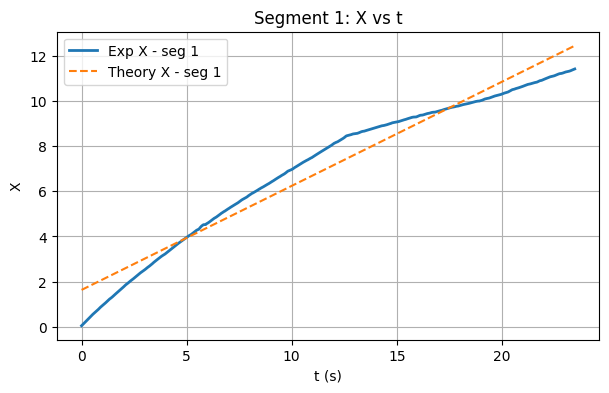

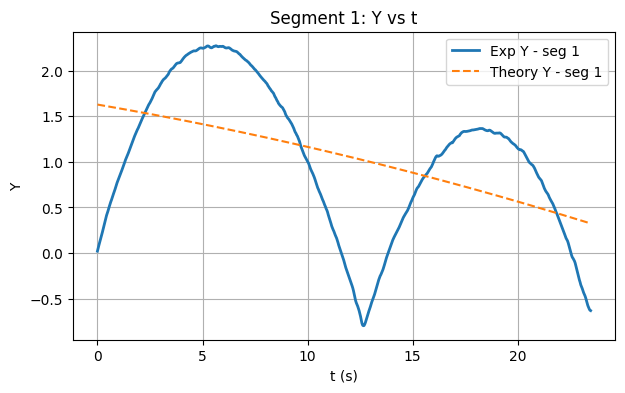

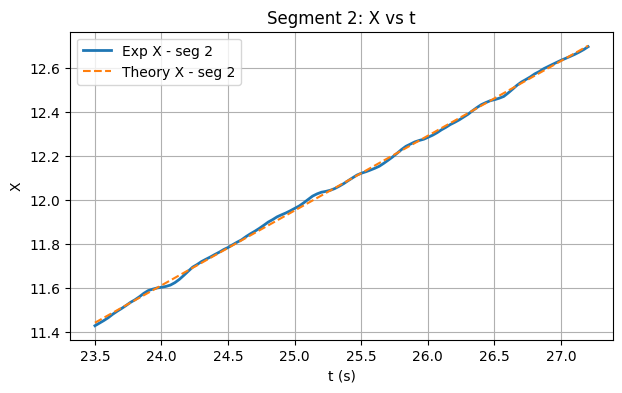

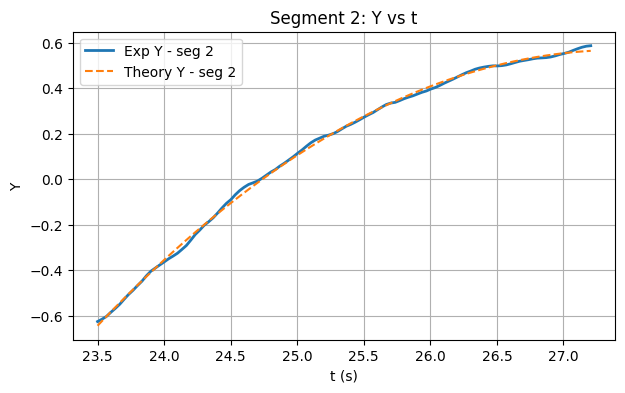

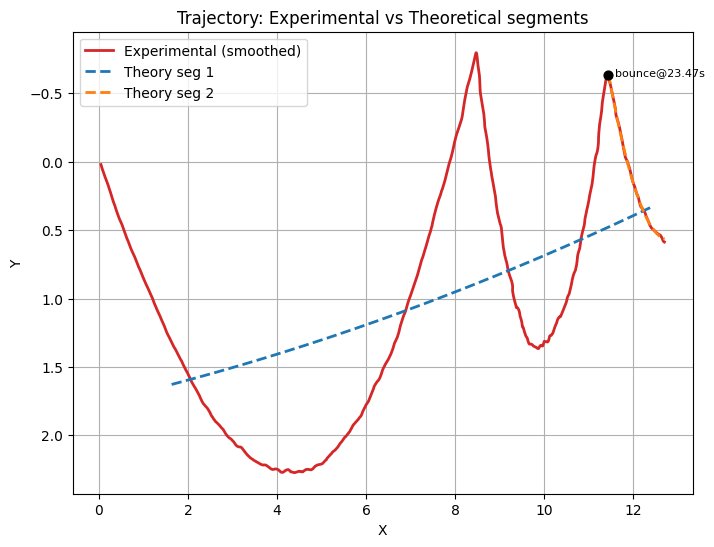


=== Per-segment fitted parameters ===
Segment 1: global t in [0.000,23.466], v0x=0.461, v0y=-0.040, g=0.001
Segment 2: global t in [23.500,27.205], v0x=0.340, v0y=0.617, g=0.157


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, find_peaks
from scipy.optimize import curve_fit

# ========== PARAMETERS ==========
file_path = "Untitled spreadsheet - Sheet1 (1).csv"
savgol_window = 11   # odd
savgol_poly = 3
impact_dt = 0.06     # seconds window to sample pre/post impact velocities for restitution
peak_thresh_factor = 3.0  # threshold multiplier for |ay| peak detection

# ========== LOAD & CLEAN ==========
df = pd.read_csv(file_path, header=0)
df = df.rename(columns={"Unnamed: 0":"t","Unnamed: 1":"x","Unnamed: 2":"y"})
for c in ["t","x","y"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")
df = df.dropna().reset_index(drop=True)

# ========== TIME ZERO ==========
t = df["t"].values
t = t - t.min()
x = df["x"].values
y = df["y"].values

# ========== DERIVATIVES & SMOOTH ==========
vx = np.gradient(x, t)
vy = np.gradient(y, t)
ax = np.gradient(vx, t)
ay = np.gradient(vy, t)

if savgol_window >= len(t):
    savgol_window = len(t) - (1 - len(t)%2)

x_s  = savgol_filter(x, savgol_window, savgol_poly)
y_s  = savgol_filter(y, savgol_window, savgol_poly)
vx_s = savgol_filter(vx, savgol_window, savgol_poly)
vy_s = savgol_filter(vy, savgol_window, savgol_poly)
ax_s = savgol_filter(ax, savgol_window, savgol_poly)
ay_s = savgol_filter(ay, savgol_window, savgol_poly)

# ========== DETECT BOUNCES ==========
# find peaks in abs(ay_s) above threshold
threshold = np.std(ay_s) * peak_thresh_factor
peaks, props = find_peaks(np.abs(ay_s), height=threshold)

# keep only peaks where vy changes sign around the peak (down -> up)
bounce_idxs = []
for p in peaks:
    if p-1 >= 0 and p+1 < len(vy_s):
        if vy_s[p-1] < 0 and vy_s[p+1] > 0:
            bounce_idxs.append(p)
bounce_idxs = sorted(bounce_idxs)

# optionally limit to first two bounces if you know there are two
# bounce_idxs = bounce_idxs[:2]

bounce_times = t[bounce_idxs]
print("Detected bounce indices:", bounce_idxs)
print("Detected bounce times (s):", np.round(bounce_times,3).tolist())

# ========== SPLIT INTO SEGMENTS ==========
# segments: [0: b1], [b1+1 : b2], [b2+1 : end], etc.
seg_starts = [0] + [i+1 for i in bounce_idxs]
seg_ends   = [i for i in bounce_idxs] + [len(t)-1]
segments = list(zip(seg_starts, seg_ends))

# helper: fit models
def x_model(t, v0x, x0): return x0 + v0x*t
def y_model(t, v0y, y0, g): return y0 + v0y*t - 0.5*g*t**2

fitted = []
restitutions = []

for si, (s_idx, e_idx) in enumerate(segments, start=1):
    # ensure valid segment length
    if e_idx - s_idx < 3:
        continue
    t_seg = t[s_idx:e_idx+1] - t[s_idx]   # local time reset for fitting segment
    x_seg = x_s[s_idx:e_idx+1]
    y_seg = y_s[s_idx:e_idx+1]

    # fit x and y models for this segment
    try:
        p_x, pcov_x = curve_fit(x_model, t_seg, x_seg, p0=[(x_seg[-1]-x_seg[0])/(t_seg[-1]-t_seg[0]), x_seg[0]])
        p_y, pcov_y = curve_fit(y_model, t_seg, y_seg, p0=[(y_seg[1]-y_seg[0])/(t_seg[1]-t_seg[0]), y_seg[0], 9.8])
    except Exception as ex:
        print(f"Fit failed for segment {si}: {ex}")
        continue

    v0x, x0 = p_x
    v0y, y0, g_fit = p_y

    # store fitted params (note t offset)
    fitted.append({
        "segment": si,
        "global_t_start": t[s_idx],
        "global_t_end": t[e_idx],
        "local_len": len(t_seg),
        "v0x": v0x, "x0": x0,
        "v0y": v0y, "y0": y0,
        "g": g_fit,
        "t_local": t_seg,
        "x_fit_local": x_model(t_seg, *p_x),
        "y_fit_local": y_model(t_seg, *p_y)
    })

# ========== ESTIMATE COEFFICIENTS OF RESTITUTION ==========
def sample_v_near(time_idx, tarr, varr, dt_window=impact_dt):
    t0 = tarr[time_idx]
    before_mask = (tarr >= t0 - dt_window) & (tarr < t0 - dt_window/6)
    after_mask  = (tarr >  t0 + dt_window/6) & (tarr <= t0 + dt_window)
    v_before = np.median(varr[before_mask]) if np.any(before_mask) else np.nan
    v_after  = np.median(varr[after_mask]) if np.any(after_mask) else np.nan
    return v_before, v_after

for bidx in bounce_idxs:
    v_bef, v_aft = sample_v_near(bidx, t, vy_s, impact_dt)
    e = np.abs(v_aft)/np.abs(v_bef) if np.isfinite(v_bef) and abs(v_bef)>1e-9 else np.nan
    restitutions.append({"index": bidx, "time": t[bidx], "v_before": v_bef, "v_after": v_aft, "e": e})

# print restitution summary
for i, r in enumerate(restitutions, start=1):
    print(f"Bounce {i}: t={r['time']:.3f}s, v_before={r['v_before']:.3f}, v_after={r['v_after']:.3f}, e={np.nan if np.isnan(r['e']) else round(r['e'],3)}")

# ========== PLOTTING: experimental vs theoretical for each segment ==========
for fit in fitted:
    si = fit["segment"]
    t0_global = fit["global_t_start"]
    t_local = fit["t_local"]
    # global times for plotting
    t_global_seg = t_local + t0_global
    # theoretical in global frame
    x_theory_global = fit["x_fit_local"]
    y_theory_global = fit["y_fit_local"]

    # Experimental (smoothed) in this segment
    idx0 = int(t0_global == t[0] and 0 or np.where(t==t0_global)[0][0])
    idx1 = idx0 + len(t_local) - 1
    x_exp_seg = x_s[idx0:idx1+1]
    y_exp_seg = y_s[idx0:idx1+1]

    # Plot X vs t for this segment
    plt.figure(figsize=(7,4))
    plt.plot(t_global_seg, x_exp_seg, label=f"Exp X - seg {si}", linewidth=2)
    plt.plot(t_global_seg, x_theory_global, '--', label=f"Theory X - seg {si}")
    plt.xlabel("t (s)"); plt.ylabel("X"); plt.title(f"Segment {si}: X vs t"); plt.grid(); plt.legend()
    plt.show()

    # Plot Y vs t for this segment
    plt.figure(figsize=(7,4))
    plt.plot(t_global_seg, y_exp_seg, label=f"Exp Y - seg {si}", linewidth=2)
    plt.plot(t_global_seg, y_theory_global, '--', label=f"Theory Y - seg {si}")
    plt.xlabel("t (s)"); plt.ylabel("Y"); plt.title(f"Segment {si}: Y vs t"); plt.grid(); plt.legend()
    plt.show()

# ========== COMBINED TRAJECTORY PLOT (Y vs X) showing all segments + theoretical arcs ==========
plt.figure(figsize=(8,6))
plt.plot(x_s, y_s, label="Experimental (smoothed)", linewidth=2, color='tab:red')

# overlay theoretical arcs (global coords)
for fit in fitted:
    t0_global = fit["global_t_start"]
    t_local = fit["t_local"]
    t_global_seg = t_local + t0_global
    x_theory_global = fit["x_fit_local"]
    y_theory_global = fit["y_fit_local"]
    plt.plot(x_theory_global, y_theory_global, '--', label=f"Theory seg {fit['segment']}", linewidth=2)

# mark bounce points
for bidx in bounce_idxs:
    plt.scatter(x_s[bidx], y_s[bidx], marker='o', color='k', zorder=5, s=40)
    plt.text(x_s[bidx], y_s[bidx], f"  bounce@{t[bidx]:.2f}s", fontsize=8)

plt.xlabel("X"); plt.ylabel("Y"); plt.title("Trajectory: Experimental vs Theoretical segments"); plt.legend(); plt.grid()
plt.gca().invert_yaxis()  # if your video coordinate has y down positive, you may invert; remove if not needed
plt.show()

# ========== PRINT FIT SUMMARY ==========
print("\n=== Per-segment fitted parameters ===")
for fit in fitted:
    print(f"Segment {fit['segment']}: global t in [{fit['global_t_start']:.3f},{fit['global_t_end']:.3f}]"
          f", v0x={fit['v0x']:.3f}, v0y={fit['v0y']:.3f}, g={fit['g']:.3f}")


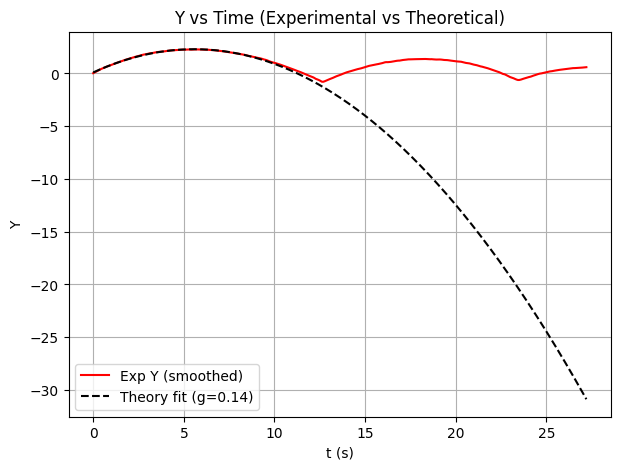

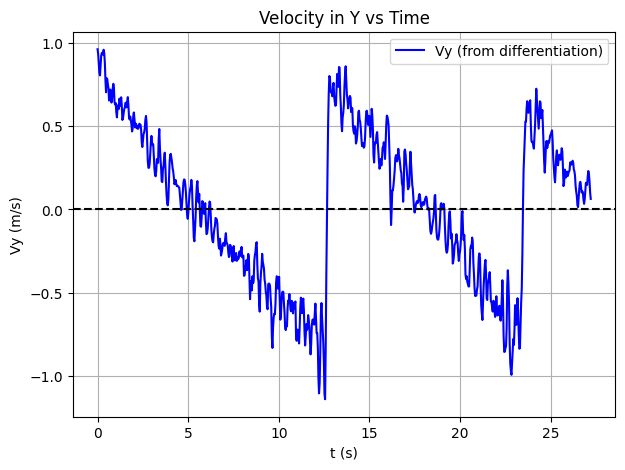

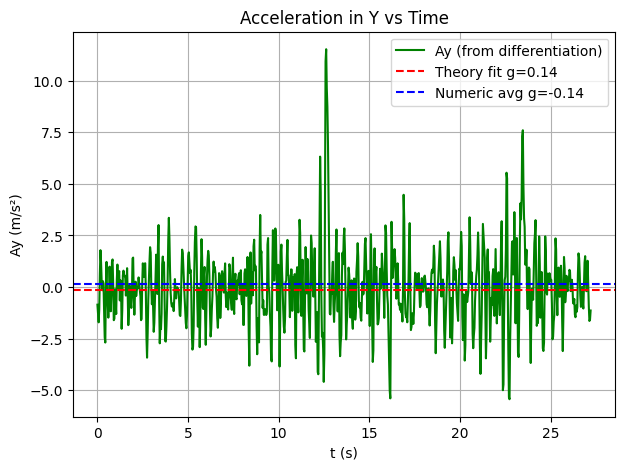


=== Gravity Estimation ===
From curve fitting: g ≈ 0.142 m/s²
From differentiation: g ≈ -0.139 m/s²


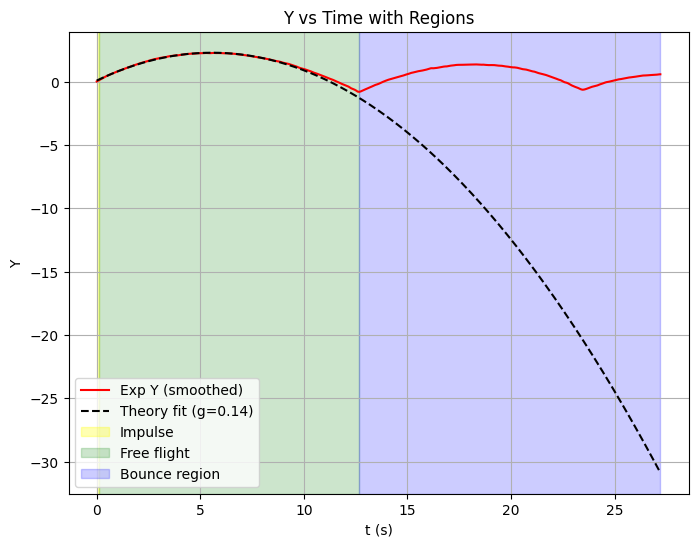

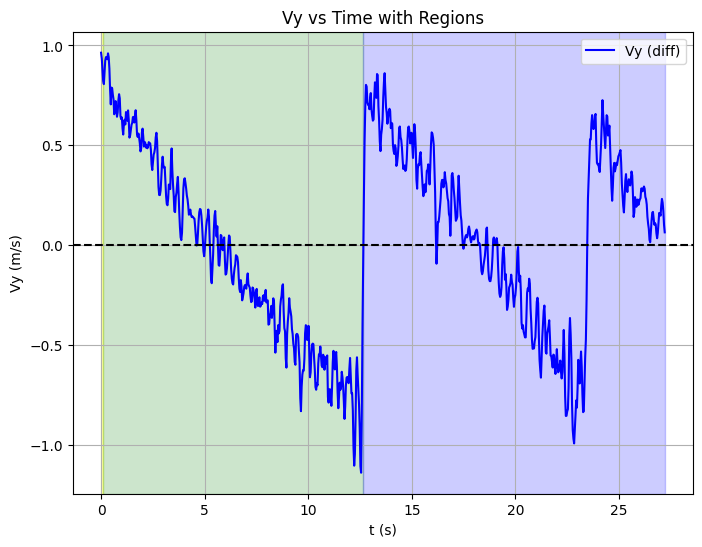

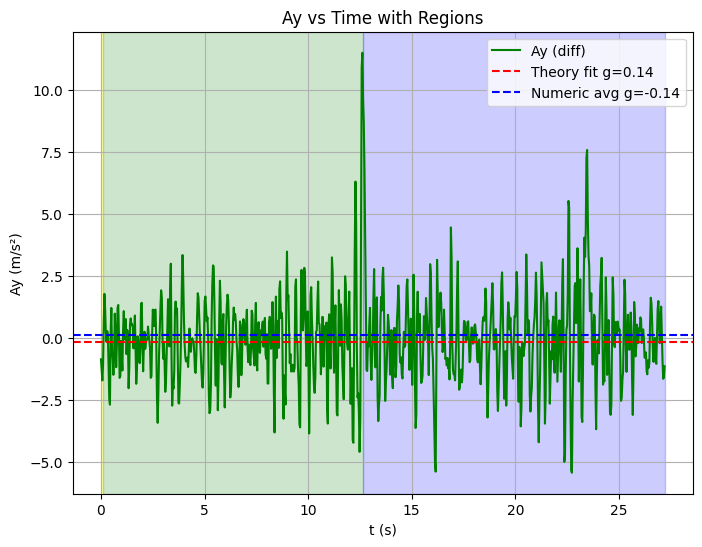


=== Gravity Estimation ===
From curve fitting: g ≈ 0.142 m/s²
From differentiation: g ≈ -0.139 m/s²

Regions: 
 Yellow  = Impulse region (throw) 
 Green   = Free flight (gravity + air drag) 
 Blue    = Bounce region (ground reaction impulse) 


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit

# ========= 1. Load & clean data =========
file_path = "Untitled spreadsheet - Sheet1 (1).csv"
data = pd.read_csv(file_path, header=0)
data = data.rename(columns={"Unnamed: 0": "t", "Unnamed: 1": "x", "Unnamed: 2": "y"})

for col in ["t", "x", "y"]:
    data[col] = pd.to_numeric(data[col], errors="coerce")

data = data.dropna().reset_index(drop=True)

# ========= 2. Reset time =========
t = data["t"].values
t = t - t.min()
y = data["y"].values

# ========= 3. Smooth y =========
savgol_window, savgol_poly = 11, 3
if savgol_window >= len(t):
    savgol_window = len(t) - (1 - len(t) % 2)

y_s = savgol_filter(y, savgol_window, savgol_poly)

# ========= 4. Fit parabola (theory) =========
def y_model(t, v0y, y0, g):
    return y0 + v0y*t - 0.5*g*t**2

cut_index = np.argmax(np.gradient(y_s, t) > 0)
if cut_index == 0:
    cut_index = len(t) // 3
t_fit, y_fit = t[:cut_index], y_s[:cut_index]

popt, _ = curve_fit(y_model, t_fit, y_fit, p0=[0, y_fit[0], 9.8])
v0y_fit, y0_fit, g_fit = popt

y_theory = y_model(t, v0y_fit, y0_fit, g_fit)

# ========= 5. Numerical differentiation =========
vy = np.gradient(y_s, t)   # velocity
ay = np.gradient(vy, t)    # acceleration
g_numeric = np.mean(ay[:cut_index])  # average before bounce

# ========= 6. Define regions =========
impulse_end = t[3]   # first few points = impulse
bounce_start = t[np.argmin(y_s)]  # approximate time of first bounce

# ========= 7. Plot with regions =========

# (a) Y vs T
plt.figure(figsize=(8,6))
plt.plot(t, y_s, 'r', label="Exp Y (smoothed)")
plt.plot(t, y_theory, 'k--', label=f"Theory fit (g={g_fit:.2f})")
plt.axvspan(t[0], impulse_end, color='yellow', alpha=0.3, label="Impulse")
plt.axvspan(impulse_end, bounce_start, color='green', alpha=0.2, label="Free flight")
plt.axvspan(bounce_start, t[-1], color='blue', alpha=0.2, label="Bounce region")
plt.title("Y vs Time with Regions")
plt.xlabel("t (s)"); plt.ylabel("Y")
plt.legend(); plt.grid()
plt.show()

# (b) Velocity vs Time
plt.figure(figsize=(8,6))
plt.plot(t, vy, 'b', label="Vy (diff)")
plt.axhline(0, color="k", linestyle="--")
plt.axvspan(t[0], impulse_end, color='yellow', alpha=0.3)
plt.axvspan(impulse_end, bounce_start, color='green', alpha=0.2)
plt.axvspan(bounce_start, t[-1], color='blue', alpha=0.2)
plt.title("Vy vs Time with Regions")
plt.xlabel("t (s)"); plt.ylabel("Vy (m/s)")
plt.legend(); plt.grid()
plt.show()

# (c) Acceleration vs Time
plt.figure(figsize=(8,6))
plt.plot(t, ay, 'g', label="Ay (diff)")
plt.axhline(-g_fit, color="r", linestyle="--", label=f"Theory fit g={g_fit:.2f}")
plt.axhline(-g_numeric, color="b", linestyle="--", label=f"Numeric avg g={g_numeric:.2f}")
plt.axvspan(t[0], impulse_end, color='yellow', alpha=0.3)
plt.axvspan(impulse_end, bounce_start, color='green', alpha=0.2)
plt.axvspan(bounce_start, t[-1], color='blue', alpha=0.2)
plt.title("Ay vs Time with Regions")
plt.xlabel("t (s)"); plt.ylabel("Ay (m/s²)")
plt.legend(); plt.grid()
plt.show()

# ========= 8. Print summary =========
print("\n=== Gravity Estimation ===")
print(f"From curve fitting: g ≈ {g_fit:.3f} m/s²")
print(f"From differentiation: g ≈ {g_numeric:.3f} m/s²")
print("\nRegions: ")
print(" Yellow  = Impulse region (throw) ")
print(" Green   = Free flight (gravity + air drag) ")
print(" Blue    = Bounce region (ground reaction impulse) ")


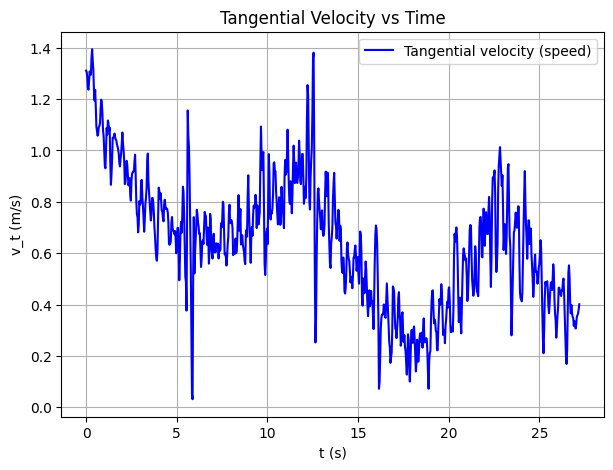

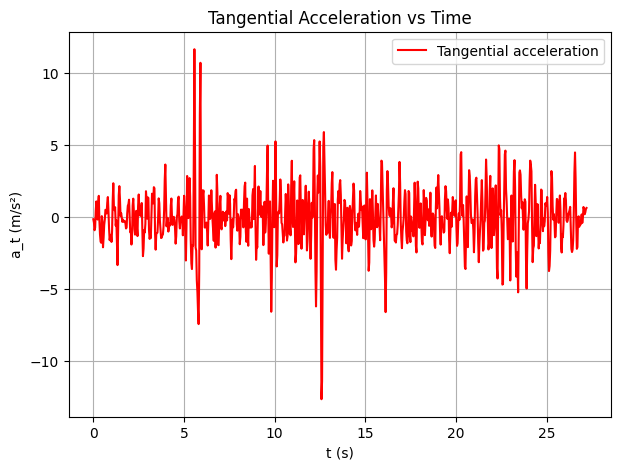

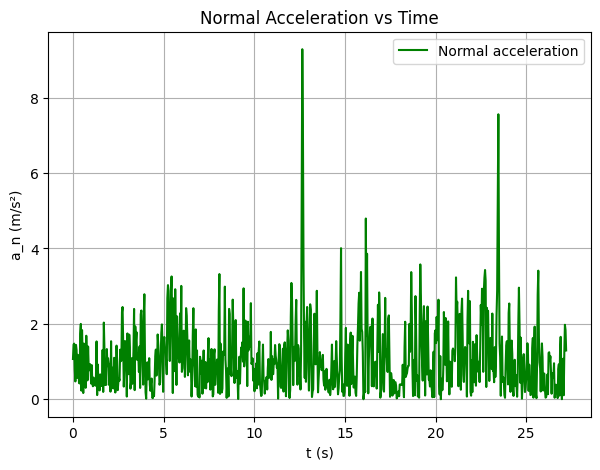

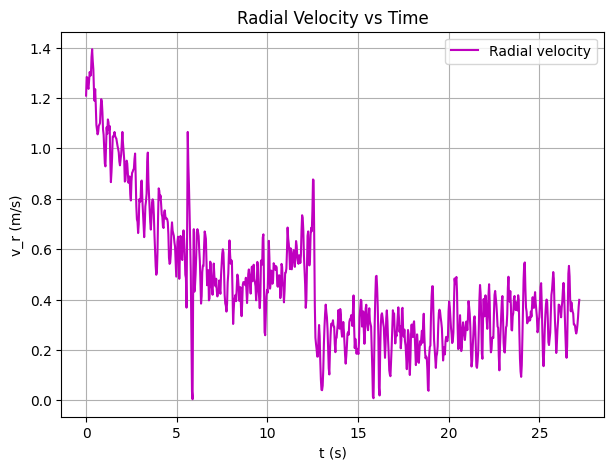

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# ========= Load & clean =========
file_path = "Untitled spreadsheet - Sheet1 (1).csv"
data = pd.read_csv(file_path, header=0)
data = data.rename(columns={"Unnamed: 0": "t", "Unnamed: 1": "x", "Unnamed: 2": "y"})

for col in ["t", "x", "y"]:
    data[col] = pd.to_numeric(data[col], errors="coerce")

data = data.dropna().reset_index(drop=True)

t = data["t"].values
t = t - t.min()
x = data["x"].values
y = data["y"].values

# ========= Smoothing =========
savgol_window, savgol_poly = 11, 3
if savgol_window >= len(t):
    savgol_window = len(t) - (1 - len(t) % 2)

x_s = savgol_filter(x, savgol_window, savgol_poly)
y_s = savgol_filter(y, savgol_window, savgol_poly)

# ========= Velocities =========
vx = np.gradient(x_s, t)
vy = np.gradient(y_s, t)
v = np.sqrt(vx**2 + vy**2)

# ========= Accelerations =========
ax = np.gradient(vx, t)
ay = np.gradient(vy, t)
a = np.sqrt(ax**2 + ay**2)

# ========= Tangential & Normal components =========
# Tangential acceleration = dv/dt
at = np.gradient(v, t)

# Normal acceleration = sqrt(total^2 - tangential^2)
an = np.sqrt(np.clip(a**2 - at**2, 0, None))

# ========= Radial velocity =========
r = np.sqrt(x_s**2 + y_s**2)
vr = (x_s*vx + y_s*vy) / r  # projection of v along r

# ========= Plotting =========

# Velocity tangential vs time
plt.figure(figsize=(7,5))
plt.plot(t, v, 'b', label="Tangential velocity (speed)")
plt.xlabel("t (s)"); plt.ylabel("v_t (m/s)")
plt.title("Tangential Velocity vs Time")
plt.legend(); plt.grid(); plt.show()

# Tangential acceleration vs time
plt.figure(figsize=(7,5))
plt.plot(t, at, 'r', label="Tangential acceleration")
plt.xlabel("t (s)"); plt.ylabel("a_t (m/s²)")
plt.title("Tangential Acceleration vs Time")
plt.legend(); plt.grid(); plt.show()

# Normal acceleration vs time
plt.figure(figsize=(7,5))
plt.plot(t, an, 'g', label="Normal acceleration")
plt.xlabel("t (s)"); plt.ylabel("a_n (m/s²)")
plt.title("Normal Acceleration vs Time")
plt.legend(); plt.grid(); plt.show()

# Radial velocity vs time
plt.figure(figsize=(7,5))
plt.plot(t, vr, 'm', label="Radial velocity")
plt.xlabel("t (s)"); plt.ylabel("v_r (m/s)")
plt.title("Radial Velocity vs Time")
plt.legend(); plt.grid(); plt.show()


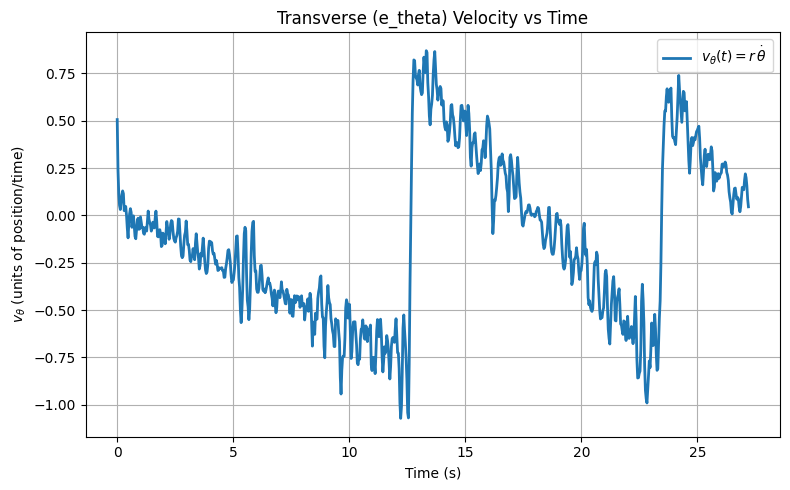

v_theta stats (valid points):
  min = -1.071, max = 0.8691, median = -0.1525


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# --------- User settings ---------
file_path = "Untitled spreadsheet - Sheet1 (1).csv"  # change if needed
savgol_window = 11   # odd integer, tune for smoothing
savgol_poly = 3

# --------- Load & clean ----------
df = pd.read_csv(file_path, header=0)
df = df.rename(columns={"Unnamed: 0": "t", "Unnamed: 1": "x", "Unnamed: 2": "y"})
for c in ["t","x","y"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")
df = df.dropna().reset_index(drop=True)

t = df["t"].values
t = t - t.min()
x = df["x"].values
y = df["y"].values

# --------- Smooth positions ----------
if savgol_window >= len(t):
    savgol_window = len(t) - (1 - len(t) % 2)  # make odd and smaller if needed

x_s = savgol_filter(x, savgol_window, savgol_poly)
y_s = savgol_filter(y, savgol_window, savgol_poly)

# --------- Compute velocities (central differences) ----------
vx = np.gradient(x_s, t)
vy = np.gradient(y_s, t)

# --------- Polar quantities ----------
r = np.sqrt(x_s**2 + y_s**2)

# avoid division by zero: set tiny floor for r^2
r2 = r**2
eps = 1e-9
r2_safe = np.where(r2 < eps, eps, r2)

# theta_dot = (x*vy - y*vx) / r^2
theta_dot = (x_s * vy - y_s * vx) / r2_safe

# v_theta = r * theta_dot
v_theta = r * theta_dot

# Optional: mask points where r is extremely small (near origin)
mask_valid = r > 1e-3  # adjust threshold if your units differ

# --------- Plot v_theta vs time ----------
plt.figure(figsize=(8,5))
plt.plot(t[mask_valid], v_theta[mask_valid], linewidth=2, label=r"$v_\theta(t)=r\,\dot\theta$")
plt.xlabel("Time (s)")
plt.ylabel(r"$v_\theta$ (units of position/time)")
plt.title("Transverse (e_theta) Velocity vs Time")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --------- Optional diagnostics print ----------
print("v_theta stats (valid points):")
print(f"  min = {np.nanmin(v_theta[mask_valid]):.4g}, max = {np.nanmax(v_theta[mask_valid]):.4g}, median = {np.median(v_theta[mask_valid]):.4g}")


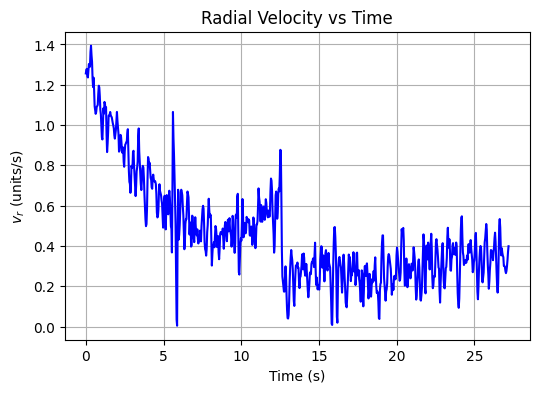

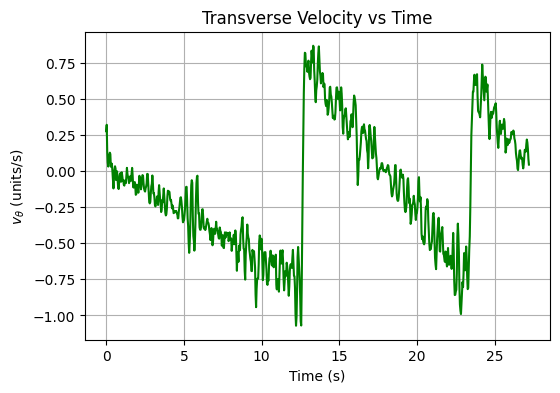

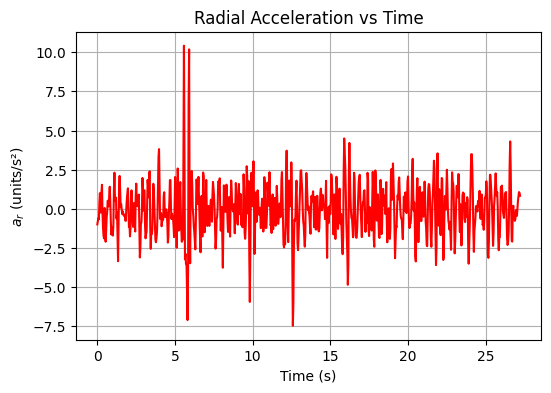

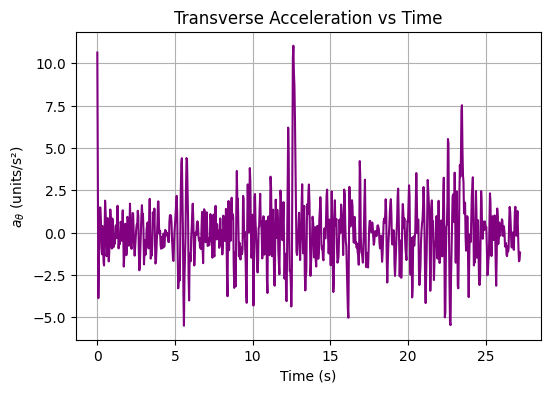

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# --------- Load data ----------
file_path = "Untitled spreadsheet - Sheet1 (1).csv"
df = pd.read_csv(file_path, header=0)
df = df.rename(columns={"Unnamed: 0": "t", "Unnamed: 1": "x", "Unnamed: 2": "y"})
for c in ["t","x","y"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")
df = df.dropna().reset_index(drop=True)

t = df["t"].values
t = t - t.min()
x = df["x"].values
y = df["y"].values

# --------- Smooth coordinates ----------
savgol_window, savgol_poly = 11, 3
if savgol_window >= len(t):
    savgol_window = len(t) - (1 - len(t) % 2)

x_s = savgol_filter(x, savgol_window, savgol_poly)
y_s = savgol_filter(y, savgol_window, savgol_poly)

# --------- Convert to polar ----------
r = np.sqrt(x_s**2 + y_s**2)
theta = np.arctan2(y_s, x_s)

# --------- Derivatives ----------
r_dot = np.gradient(r, t)
r_ddot = np.gradient(r_dot, t)
theta_dot = np.gradient(theta, t)
theta_ddot = np.gradient(theta_dot, t)

# --------- Polar velocity components ----------
v_r = r_dot
v_theta = r * theta_dot

# --------- Polar acceleration components ----------
a_r = r_ddot - r * theta_dot**2
a_theta = r * theta_ddot + 2 * r_dot * theta_dot

# --------- Plotting ---------
plt.figure(figsize=(6,4))
plt.plot(t, v_r, color="blue")
plt.xlabel("Time (s)"); plt.ylabel(r"$v_r$ (units/s)")
plt.title("Radial Velocity vs Time")
plt.grid(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(t, v_theta, color="green")
plt.xlabel("Time (s)"); plt.ylabel(r"$v_\theta$ (units/s)")
plt.title("Transverse Velocity vs Time")
plt.grid(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(t, a_r, color="red")
plt.xlabel("Time (s)"); plt.ylabel(r"$a_r$ (units/s²)")
plt.title("Radial Acceleration vs Time")
plt.grid(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(t, a_theta, color="purple")
plt.xlabel("Time (s)"); plt.ylabel(r"$a_\theta$ (units/s²)")
plt.title("Transverse Acceleration vs Time")
plt.grid(); plt.show()
